# Economicos

In [1]:
%%capture
import sys
!ln -s ../syntheticml .
!{sys.executable} -m pip install -U -r ../requirements.txt
!{sys.executable} -m pip install -U kaleido

In [2]:
import pandas as pd
import numpy as np
df = pd.read_parquet('../datasets/economicos/raw/full_dedup_economicos_step0.parquet');
df.sample(3)

,url,description,price,property_type,transaction_type,state,county,publication_date,rooms,bathrooms,m_built,m_size,source,title,address,owner,_price
572021,https://www.economicos.cl/propiedades/arriendo...,"SE ARRIENDA POR MESES, ESTACIONAMIENTOS TECHAD...",$ 65.000,Estacionamiento,Arriendo,Valparaíso,Valparaíso,2020-06-26 15:50:19,NaN,NaN,15.0,NaN,None,ARRIENDO ESTACIONAMIENTOS CENTRO DE VALPARAISO,"BLANCO Valparaíso, Valparaíso",ISA,2.264789
397767,https://www.economicos.cl/propiedades/se-vende...,Se Vende Derecho de Llaves de Pub Restaurante ...,$ 100,Negocio/Patentes/Derechos de llave,Venta,Metropolitana de Santiago,Vitacura,2018-04-29 11:35:23,NaN,NaN,489.0,NaN,None,Se vende Derecho de Llaves Pub Restaurante en ...,"Vitacura Vitacura, Metropolitana de Santiago",None,0.003703
248208,https://www.economicos.cl/propiedades/arriendo...,Se arriendan piezas amobladas servicios básic...,$ 140.000,Residencial/Pieza,Arriendo,Metropolitana de Santiago,Macul,2019-01-05 11:27:33,NaN,NaN,NaN,NaN,None,Arriendo de piezas,"Avda marathon con agricola Macul, Metropolita...",None,5.078759


In [3]:
%%capture
from syntheticml.data.synthetic import Synthetic, MODELS
category_columns=("property_type", "transaction_type", "state", "county", "rooms", "bathrooms", "m_built", "m_size", "source", )
# TODO: Estudiar implicancia de valores nulos en categorias y numeros
df_converted = df.fillna(dict(
        property_type = "None",
        transaction_type = "None",
        state = "None",
        county = "None",
        rooms = -1,
        bathrooms = -1,
        m_built = -1,
        m_size = -1,
        source = "None"
)).fillna(-1).astype({k: 'str' for k in ("description", "price", "title", "address", "owner",)})
df_converted = df.replace(to_replace="None", value=np.nan).replace(to_replace=-1, value=np.nan).dropna().astype({k: 'str' for k in ("description", "price", "title", "address", "owner",)})
basedate = pd.Timestamp('2017-12-01')
dtime = df_converted.pop("publication_date")
df_converted["publication_date"] = dtime.apply(lambda x: (x - basedate).days)
syn = Synthetic(df_converted, 
        id="url", 
        category_columns=category_columns,
        text_columns=("description", "price", "title", "address", "owner", ),
        exclude_columns=tuple(),
        synthetic_folder = "../datasets/economicos/synth",
        models=['copulagan', 'tvae', 'gaussiancopula', 'ctgan', 'smote-enc', 'tddpm_mlp'],
        n_sample = df_converted.shape[0],
        target_column="_price",
        max_cpu_pool=1
)


In [4]:
%%capture
syn.process()
#syn.process(remaining_columns=("property_type", "transaction_type", "state",))
syn.process_scores()


## Metricas
### Continuas

In [5]:
metrics = syn.current_metrics()
metrics[~metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
3,publication_date,"[1545, 1693, 1546, 1549, 721]","[10883, 6103, 895, 320, 125]","[0.4933587197969083, 0.2766671199963734, 0.040...",False,22059.0,0.0,1470.755338,2.056273,1474.785560,...,0.493359,1545.000000,450.696000,531.000000,628.900000,1545.000000,1693.0,1693.0,1693.0,1693.000
10,_price,"[12500.0, 10500.0, 11500.0, 8500.0, 9000.0]","[104, 99, 91, 86, 85]","[0.00471462894963507, 0.00448796409628723, 0.0...",False,22059.0,0.0,110378.900259,32745.675510,174559.244908,...,0.004715,5083.869574,0.262868,6.270122,11.759796,2040.766084,12000.0,32000.0,58942.0,262695.428


### Categoricas

In [6]:
metrics[metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
0,m_built,"[140.0, 60.0, 120.0, 50.0, 70.0]","[700, 467, 444, 431, 415]","[0.031733079468697585, 0.021170497302688246, 0...",True,22059.0,22059.0
1,property_type,"[Departamento, Casa, Oficina o Casa Oficina, P...","[10592, 8911, 1553, 413, 255]","[0.480166825332064, 0.40396210163652024, 0.070...",True,22059.0,22059.0
2,rooms,"[3.0, 2.0, 4.0, 1.0, 5.0]","[6355, 4614, 4168, 2671, 2232]","[0.2880910286051045, 0.20916632666938664, 0.18...",True,22059.0,22059.0
4,m_size,"[5000.0, 50.0, 60.0, 200.0, 70.0]","[601, 342, 321, 285, 281]","[0.027245115372410353, 0.015503875968992248, 0...",True,22059.0,22059.0
5,source,[El Mercurio],[22059],[1.0],True,22059.0,22059.0
6,state,"[Metropolitana de Santiago, Valparaíso, Coquim...","[17248, 2014, 567, 558, 305]","[0.7819030781087085, 0.0913006029285099, 0.025...",True,22059.0,22059.0
7,county,"[Las Condes, Santiago, Providencia, Vitacura, ...","[3233, 2703, 1481, 1415, 1322]","[0.14656149417471326, 0.12253501971984224, 0.0...",True,22059.0,22059.0
8,bathrooms,"[2.0, 1.0, 3.0, 4.0, 5.0]","[7511, 5440, 4486, 2665, 1084]","[0.3404959426991251, 0.2466113604424498, 0.203...",True,22059.0,22059.0
9,transaction_type,"[Venta, Arriendo, Busco arriendo, Compro]","[17540, 4517, 1, 1]","[0.7951403055442223, 0.20476902851443854, 4.53...",True,22059.0,22059.0


## Scores

In [7]:
#best_model = "smote-enc_noise_682338"
best_model = "tddpm_mlp_27574"
second_best= "smote-enc_27574"
avg = syn.scores[syn.scores["type"] == "avg"]
avg.sort_values("score", ascending=False).loc[["tddpm_mlp_27574","smote-enc_27574","copulagan_27574","ctgan_27574","gaussiancopula_noise_27574","tvae_noise_27574","tvae_27574","ctgan_noise_27574","copulagan_noise_27574","gaussiancopula_27574"],["score", "DCR ST 5th", "DCR SH 5th", "DCR TH 5th"]]

,score,DCR ST 5th,DCR SH 5th,DCR TH 5th
name,,,,
tddpm_mlp_27574,0.934431,4.485095e-09,3.286367e-08,1.282491e-08
smote-enc_27574,0.927589,0.000000e+00,1.133083e-08,1.282491e-08
copulagan_27574,0.831396,1.101660e-07,2.647754e-07,1.282491e-08
ctgan_27574,0.839431,9.785199e-08,3.027409e-07,1.282491e-08
gaussiancopula_noise_27574,0.785923,2.365738e-03,2.933396e-03,1.282491e-08
tvae_noise_27574,0.804889,1.666975e-07,3.489566e-07,1.282491e-08
tvae_27574,0.787147,1.743783e-07,4.179364e-07,1.282491e-08
ctgan_noise_27574,0.806590,1.410278e-07,3.452036e-07,1.282491e-08
copulagan_noise_27574,0.831003,2.520798e-07,5.147272e-07,1.282491e-08


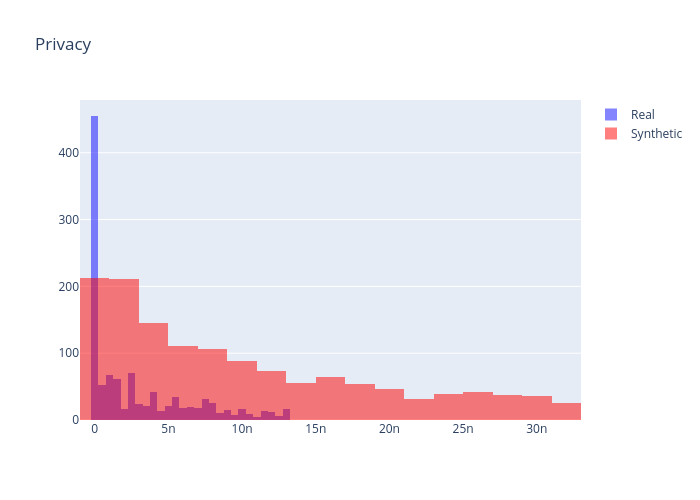

None

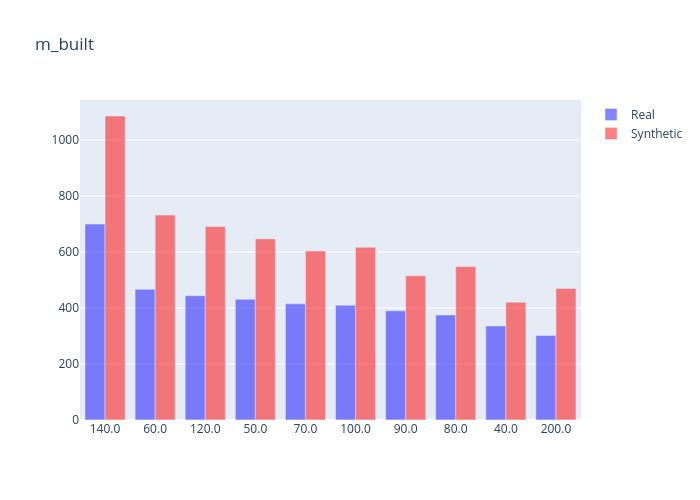

None

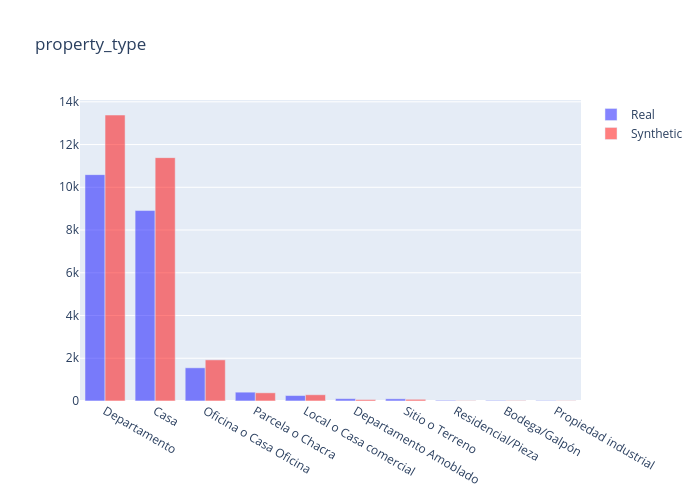

None

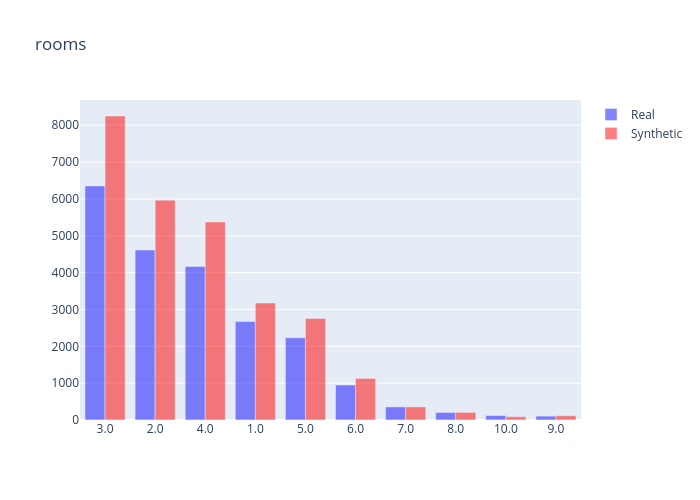

None

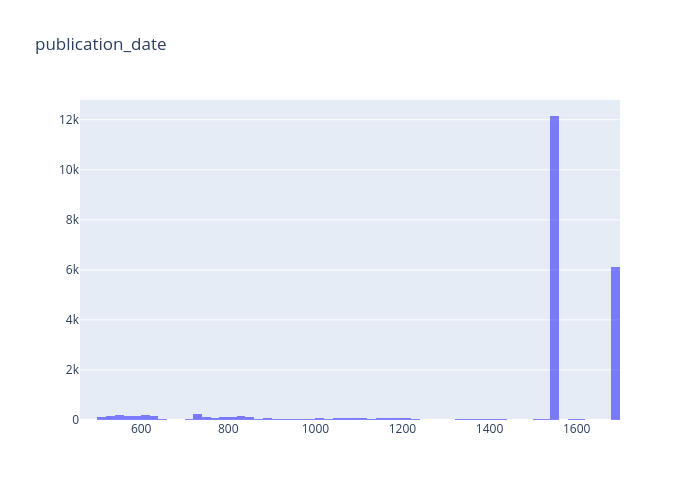

None

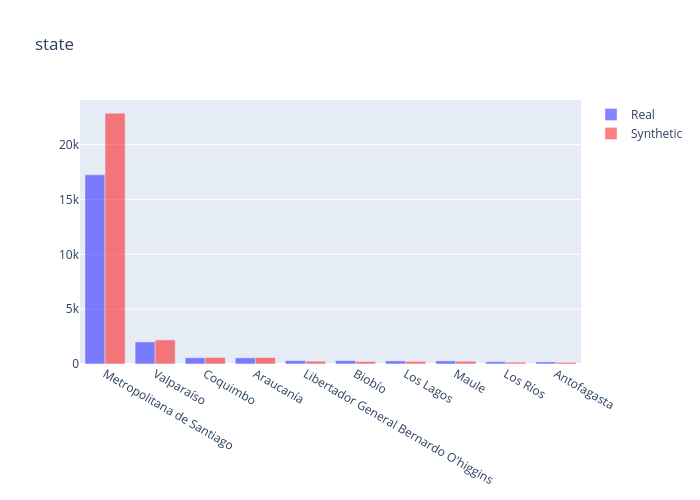

None

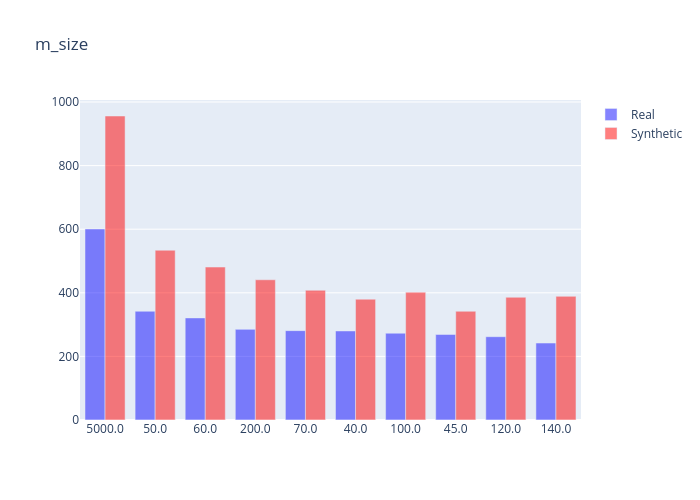

None

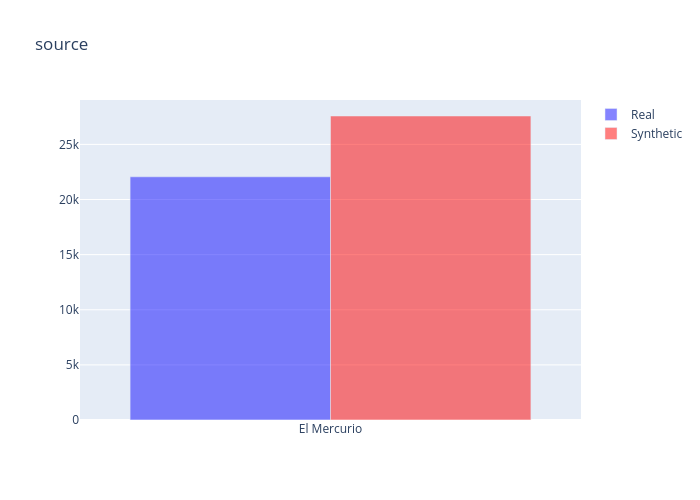

None

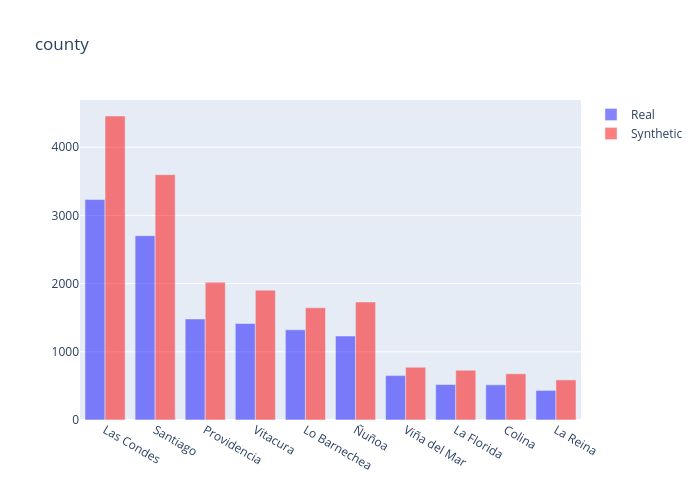

None

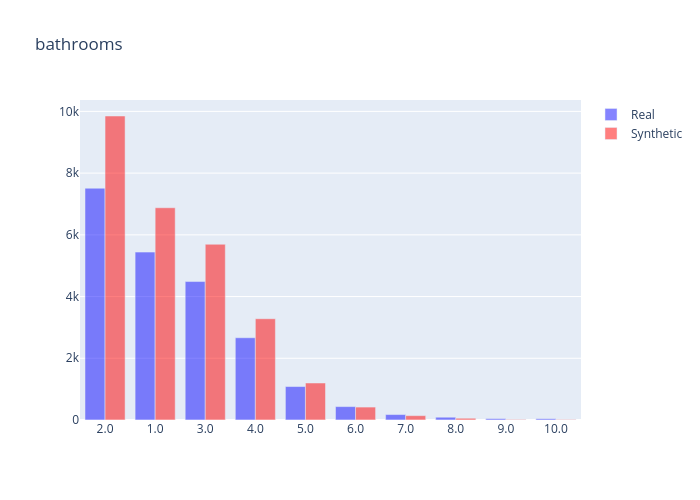

None

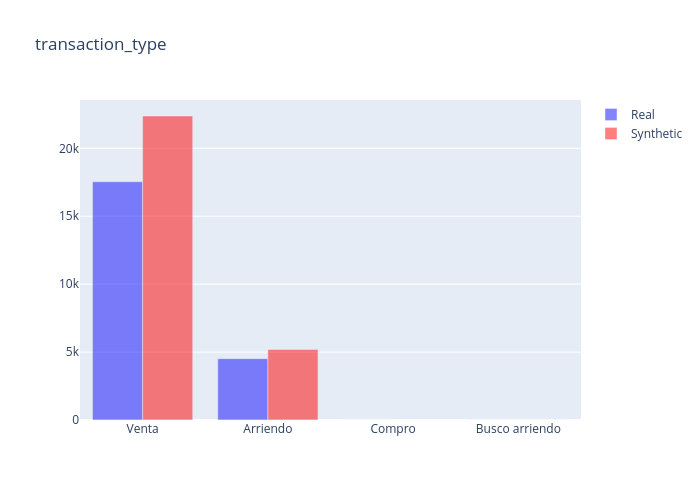

None

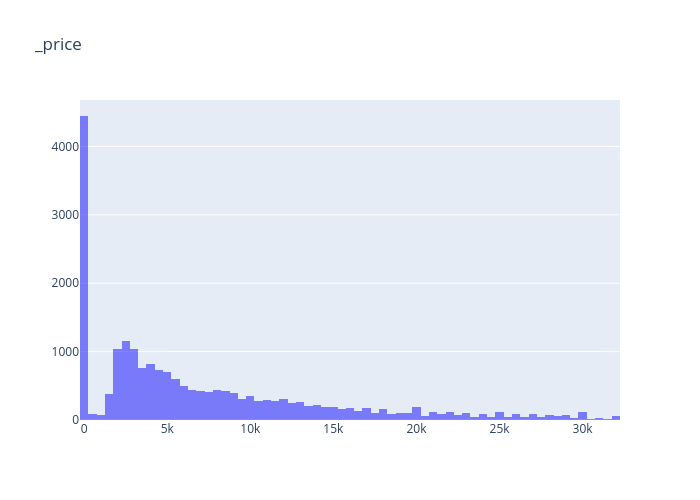

None

In [8]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))

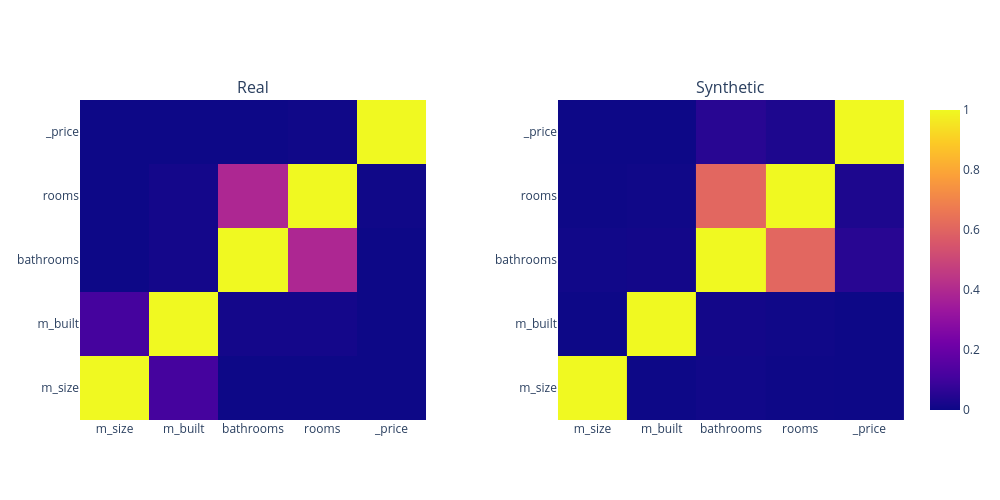

In [9]:
syn.charts.pair_corr(df.loc[:, syn.fake_data[best_model].columns].dropna(), syn.fake_data[best_model].astype({k:np.float64 for k in ('bathrooms','rooms','m_built','m_size')}), {'id', 'waterfront', 'yr_renovated'}, "_price").update_layout(dict(width=1000)).show("png")

In [10]:
syn.fake_data[best_model]

,url,publication_date,_price,property_type,transaction_type,state,county,rooms,bathrooms,m_built,m_size,source
0,0,1545.0,10.030953,Oficina o Casa Oficina,Arriendo,Antofagasta,Antofagasta,1.0,1.0,27.0,27.0,El Mercurio
1,1,1545.0,27698.727789,Casa,Venta,Metropolitana de Santiago,Lo Barnechea,5.0,4.0,304.0,503.0,El Mercurio
2,2,1545.0,13225.198217,Casa,Venta,Metropolitana de Santiago,Lo Barnechea,5.0,5.0,170.0,360.0,El Mercurio
3,3,1693.0,14.316697,Oficina o Casa Oficina,Arriendo,Valparaíso,Viña del Mar,1.0,1.0,60.0,75.0,El Mercurio
4,4,1693.0,13.493372,Departamento,Arriendo,Metropolitana de Santiago,La Florida,2.0,2.0,52.0,55.0,El Mercurio
...,...,...,...,...,...,...,...,...,...,...,...,...
27569,27569,1693.0,3326.426486,Departamento,Venta,Metropolitana de Santiago,Macul,2.0,2.0,54.0,59.0,El Mercurio
27570,27570,1693.0,9071.584365,Casa,Venta,Los Ríos,Valdivia,2.0,2.0,121.0,121.0,El Mercurio
27571,27571,1693.0,4178.298652,Departamento,Venta,Metropolitana de Santiago,Macul,2.0,2.0,56.0,68.0,El Mercurio
27572,27572,1545.0,25000.000000,Casa,Venta,Metropolitana de Santiago,Providencia,6.0,4.0,291.0,215.0,El Mercurio


In [11]:
syn.fake_data[second_best]

,url,bathrooms,transaction_type,county,rooms,m_built,property_type,_price,publication_date,m_size,state,source
0,0,2.0,Arriendo,Concón,2.0,70.0,Departamento,20.653220,1545.000000,70.0,Valparaíso,El Mercurio
1,1,1.0,Venta,Quilicura,2.0,80.0,Casa,2442.446327,1545.000000,100.0,Metropolitana de Santiago,El Mercurio
2,2,2.0,Venta,San Miguel,2.0,55.0,Departamento,4610.000000,1545.000000,55.0,Metropolitana de Santiago,El Mercurio
3,3,2.0,Arriendo,Las Condes,2.0,68.0,Departamento,30.748328,481.663989,68.0,Metropolitana de Santiago,El Mercurio
4,4,3.0,Venta,Huechuraba,3.0,74.0,Casa,4697.215552,528.354273,120.0,Metropolitana de Santiago,El Mercurio
...,...,...,...,...,...,...,...,...,...,...,...,...
27569,2569,2.0,Venta,Santo Domingo,4.0,130.0,Casa,9000.000000,1693.000000,5000.0,Valparaíso,El Mercurio
27570,2570,2.0,Venta,Las Condes,2.0,55.0,Departamento,12990.000000,1545.000000,78.0,Metropolitana de Santiago,El Mercurio
27571,2571,2.0,Venta,Vitacura,2.0,100.0,Departamento,7990.000000,534.296219,110.0,Metropolitana de Santiago,El Mercurio
27572,2572,3.0,Venta,Santo Domingo,3.0,127.0,Casa,10800.000000,1545.000000,945.0,Valparaíso,El Mercurio


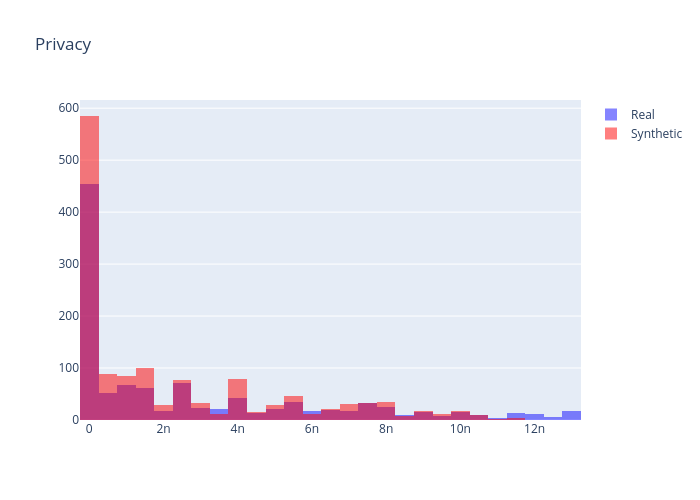

None

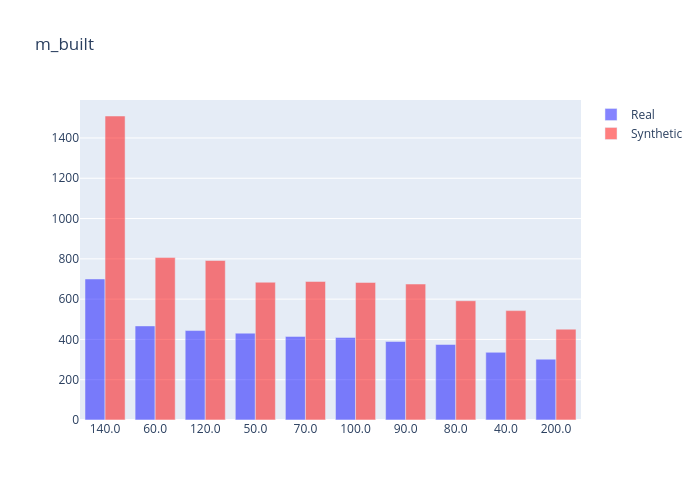

None

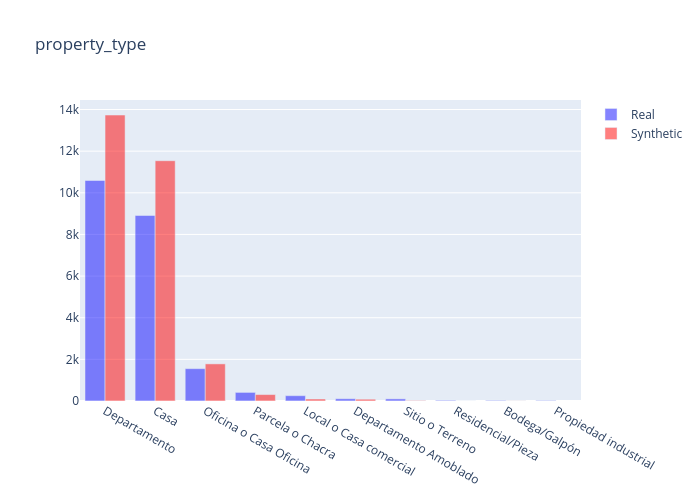

None

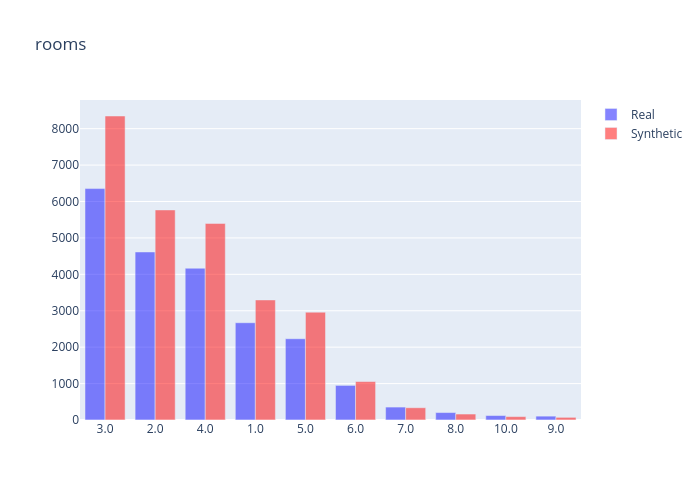

None

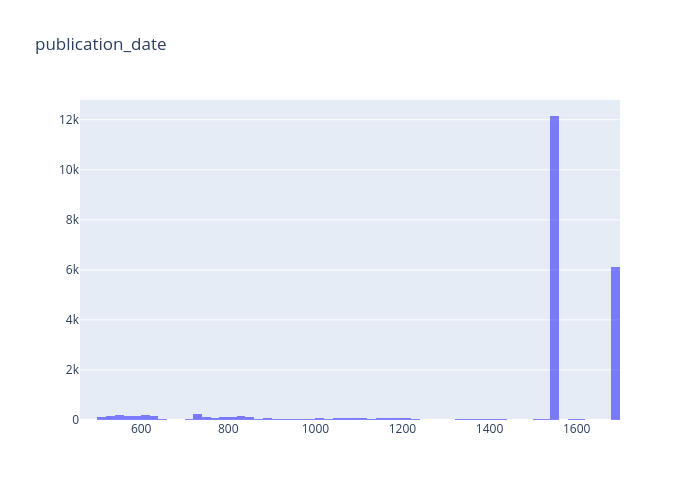

None

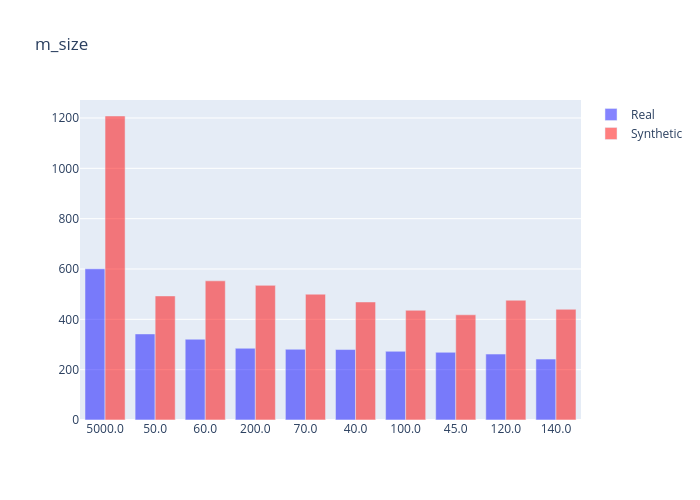

None

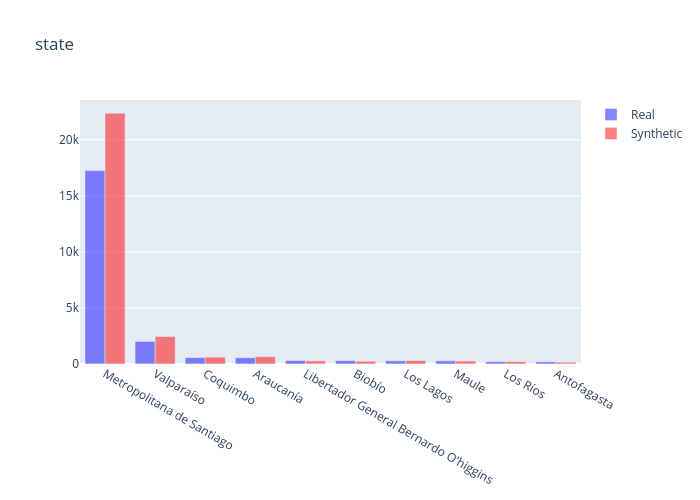

None

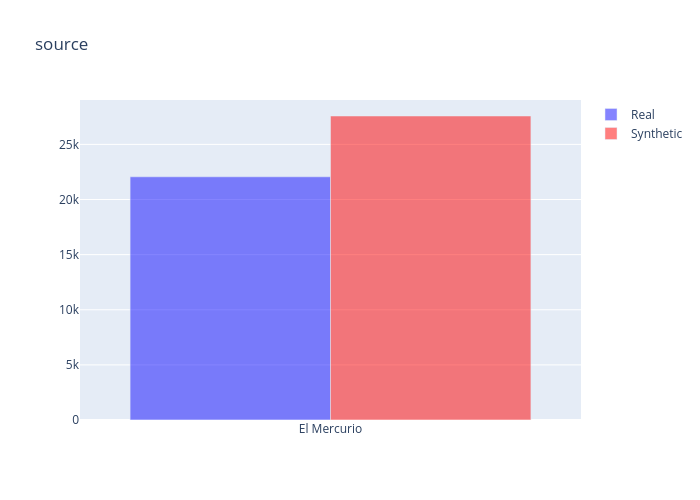

None

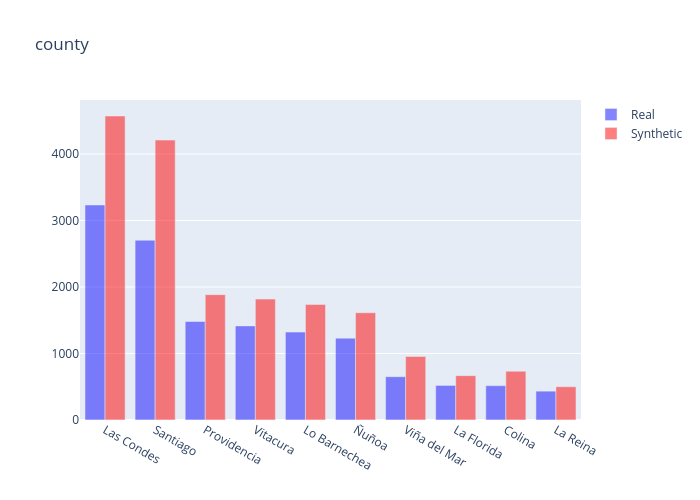

None

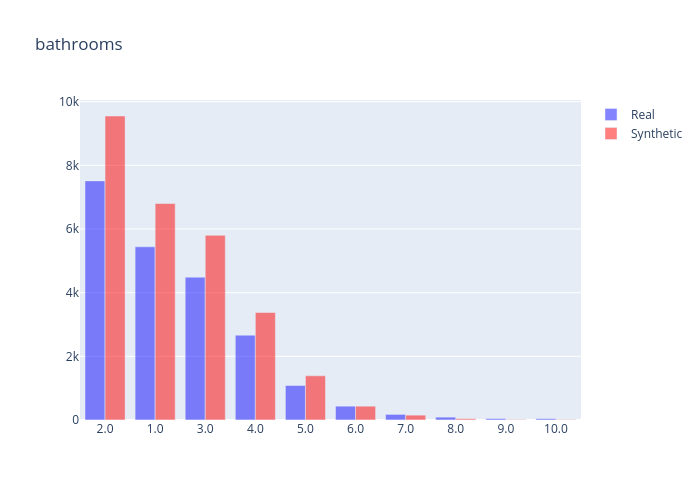

None

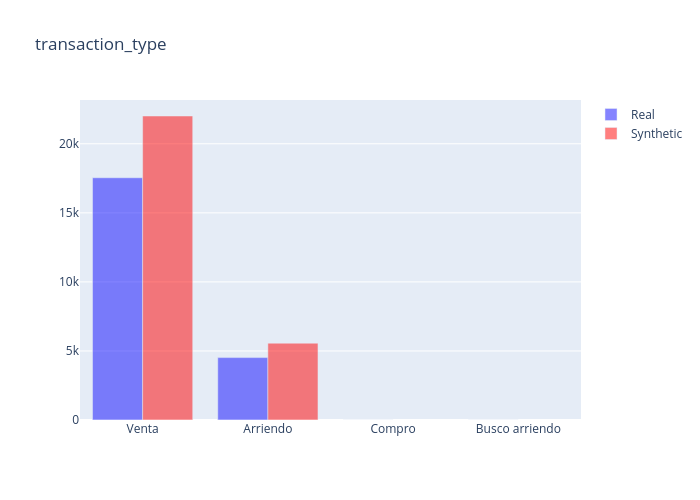

None

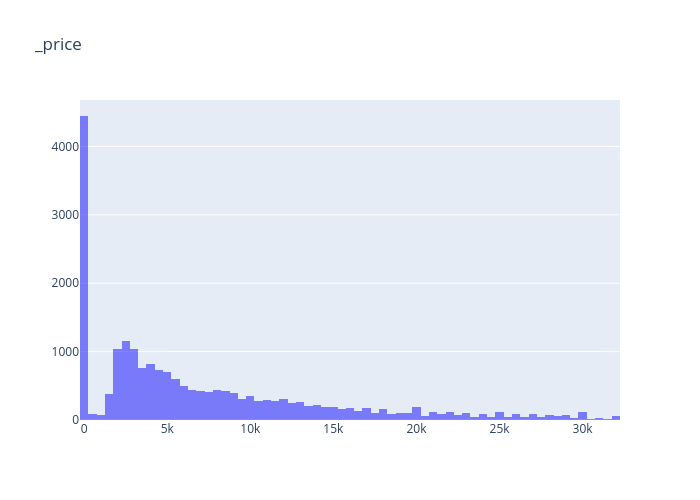

None

In [12]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(second_best, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))